# Simulate gamma ray sources in galaxy

In [81]:
#Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, laplace, lognorm
from astropy.io import fits
from astropy.table import Table,join
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import catalog_spect
from scipy.optimize import curve_fit
import astropy.coordinates as coord
from astropy import units
import healpy as hp
import makemap
from matplotlib import gridspec
from matplotlib import rc
import matplotlib.ticker
rc('font',**{'family':'serif'})
rc('text',usetex=True)


##colors
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'
colors = [c1,c2,c3,c4,c5,c6,c7,c8,c9]

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
#constants 
kpc = 3.08567758e21 #cm

##SNR distribution From Green 2015
alp_snr = 1.09
bet_snr = 3.98
H_snr = 0.083 #jian-wen xu et al 2004

Rsun = 8.3
hb = 10 #This is considered as high latitude

##This is for pulsars
model = 'SNR' #Set model to S or C
if model=='C':
    H=0.18
    alp=1.9
    bet = 5.0
if model=='S':
    H=0.33
    alp=0.2
    bet = 1.4
if model=='SNR':
    H = 0.083
    alp = alp_snr
    bet = bet_snr
#Trheshold of fermi, from 3fgl paper
fermi_thres = 5e-10

##Setting up some things for later
minflux,maxflux=-14,-5
bins = np.logspace(minflux,maxflux,25)
bins_mean = (bins[1:]+bins[:-1])/2.

lb = [(180,20),(180,5),(180,1),(20,20),(20,5),(20,1)]

##Set up bins for energy for fhl (10-1000GeV) and fgl (0.1-100GeV)
Efhl = np.logspace(1,3,100)#GeV
E3fgl_bins = np.logspace(-1,2,101)
E3fgl = (E3fgl_bins[1:]+E3fgl_bins[0:-1])/2.
E3fgl_dE = (E3fgl_bins[1:]-E3fgl_bins[0:-1])
mask_E3fgl = (E3fgl>=1)&(E3fgl<=100)
#bins in energy for our use (1-1000GeV)
Ebins = np.logspace(0,3,101)
E = (Ebins[1:]+Ebins[0:-1])/2.
dE = (Ebins[1:]-Ebins[0:-1])
mask_E3fhl = E>100
mask_E = (E>=1)&(E<=100)

Lmin_tev = 3.96e34
Lmax_tev = 1.79e38

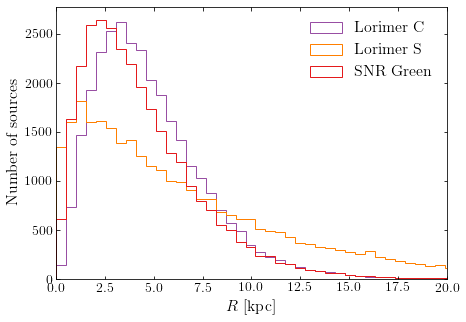

In [148]:
#Function definitions

def R_dep(R,alpha=alp, beta=bet):
    "R distribution of sources from lorimer"
    "Deprecrated?"
    return ((R/Rsun)**alpha)*np.exp(-beta*(R-Rsun)/Rsun)

Rtest = np.linspace(0,20)
atest = [(1.9,5.0),(0.2,1.4),(1.09,3.98)]
labels = ['Lorimer C','Lorimer S','SNR Green']

##Drawing random numbers
def rand_R(n,a,b,Rsun=Rsun):
    "Return random value of R, pdf is above, this is a gamma distribution"
    return np.random.gamma(a+1,1./b,n)*Rsun

# f,ax = plt.subplots(1,figsize=(7,5))
# for i,a in enumerate(atest):
#     ax.hist(rand_R(30000,a[0],a[1]),bins=np.linspace(0,25),label=labels[i],histtype='step',color=colors[i+3])
#     ax.set_xlim([0,20])
#     ax.set_xlabel(r'$R \ \mathrm{[kpc]}$',fontsize=16)
#     ax.set_ylabel(r'Number of sources',fontsize=16)
#     ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
# plt.legend(frameon=False,fontsize=16)
# plt.savefig('R_hist.pdf')

def rand_z(n,H=H):
    """Return random z from laplace distribution=exp(-abs(z))
    n = number of randoms"""
    return np.random.laplace(0,H,n)

def rand_L(u,a,Lmin,Lmax):
    if a==1:
        print "a==1, error"
        return 0
    return (u*(Lmax**(1-a)-Lmin**(1-a))+Lmin**(1-a))**(1/(1-a))

# Ltest = [1.5,1.8,2.1]
# f,ax = plt.subplots(1,figsize=(7,5))
# for i,l in enumerate(Ltest):
#     ax.hist(rand_L(np.random.rand(30000),l,2e34,2e39),bins=np.logspace(34,39,25), color=colors[i],
#            label='index = %s'%l,histtype='step',log=True)
#     ax.set_xscale('log',nonposx='clip')
#     ax.set_xlabel(r'Luminosity $\rm{ph \ s^{-1}}$',fontsize=16)
#     ax.set_ylabel(r'Number of sources',fontsize=16)
#     ax.set_ylim([0.1,2e4])
#     ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
# plt.legend(frameon=False,fontsize=16)
# plt.savefig('lum_hist.pdf')

def convertlb_px(l,b):
    "deprecrated?"
    lpix = 2*l+360
    bpix = -2*b+40
    return int(lpix),int(bpix)

def norm_spec(spec,flux,dE,mask):
    """This function normalizes the spec(actually wrong_spec below) 
    to the integrated flux from 1-100GeV
    """
    wrong_spec = spec*flux
    norm = np.sum(wrong_spec[mask]*dE[mask])
    return wrong_spec*flux/norm

def read_catalog(fn,catalog='fgl',classes=['pwn','snr','spp']):
    data = fits.getdata(fn)
    tb = Table(data)
    if catalog=='fgl':
        _E = E3fgl
        cls = np.asarray(tb['CLASS1'].tolist())
    else:
        _E = Efhl
        cls = np.asarray(tb['CLASS'].tolist())
    cls = np.char.lower(np.char.rstrip(cls,' '))
    mask = np.zeros_like(cls,dtype=bool)

    for m in classes:
        mask = (cls==m)|mask
    
    if catalog == 'fgl':
        flux = tb[mask]['Flux1000']
    if catalog == 'fhl':
        flux = tb[mask]['Flux']

    spec = catalog_spect.get_spec(fn)

    ave_spec = spec/np.amax(spec,axis=1)[:,None]
    ave_spec = ave_spec[mask]

    #for sp in ave_spec:
    #    plt.loglog(_E,sp,color='gray')
    ave_spec = 10**np.mean(np.log10(ave_spec),axis=0)
    
    hist_3fgl = np.histogram(flux,bins=bins)[0]
    total_flux = np.sum(flux)

    if catalog=='fgl':
        ind = np.mean(tb[mask]['Spectral_Index'])
    if catalog=='fhl':
        ind = np.mean(tb[mask]['PowerLaw_Index'])
    
    #print ind
        
    plotfunc = lambda E,a,b: b*(E)**-a
    #plt.loglog(E,plotfunc(E,ind,1),lw=5)
    
    spec = plotfunc(E,ind,1)
   # spec = ave_spec
    #plt.loglog(_E,spec)
    #plt.ylim([1e-15,1])
    good_spec = norm_spec(spec,total_flux,dE,mask_E)
    #print flux
    #print np.sum(good_spec[mask_E]*dE[mask_E])
    spec_normed = good_spec/np.max(good_spec)
    #plt.loglog(E,E**2*good_spec)
    return hist_3fgl,spec_normed,ind

In [23]:
##Load 3fgl data and get average spectrum and histogram of fluxes from here
file_3fgl = 'gll_psc_v16.fit'
func_log = lambda E,p: p[0]*(E/p[1])**(-p[2]-p[3]*np.log(E/p[1]))
func_Exp = lambda E,p: p[0]*(E/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(E/p[3])**p[4])
#hist_3fgl_snr,intp_3fgl_snr_normed,snr_index = read_catalog('gll_psc_v16.fit',classes=['pwn','snr','spp'])
#hist_3fgl_psr,intp_3fgl_psr_normed,psr_index = read_catalog('gll_psc_v16.fit',classes=['psr'])

hist_3fgl_snr,intp_3fgl_snr_normed,snr_index = read_catalog('gll_psc_v16.fit',catalog='fgl',
                                                            classes=['pwn','snr','spp'])

hist_3fhl_snr,intp_3fhl_snr_normed,snr_index = read_catalog('gll_psch_v13.fit',catalog='fhl',
                                                          classes=['pwn','snr','spp'])

#plt.loglog(E3fgl,E3fgl**2*intp_3fgl_snr_normed)
#plt.loglog(Efhl,Efhl**2*intp_3fhl_snr_normed)
f = lambda E,Ebr,p: p[0]*np.where(E <Ebr,(E/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(E/p[3])**p[4]),
                                  (Ebr/p[1])**(-p[2])*np.exp((p[1]/p[3])**p[4]-(Ebr/p[3])**p[4])*(E/Ebr)**-p[5])
#plt.loglog(E3fgl,f(E3fgl,[1.,0.1,1.946,6,1,2.]))
Ebr = 100
#fitter = lambda E,a,b,c: np.log10(func_Exp(E,[1,0.1,a,b,c]))
#fit, cov = curve_fit(fitter,E3fgl,np.log10(intp_3fgl_snr_normed),p0=[2,6,1])
#print fit
#f2 = lambda E,p: p[0]*E**-p[1]
##fitter2 = lambda E,a,b: np.log10(f2(E,[a,b]))
#fit2,cov2 = curve_fit(fitter2,Efhl,np.log10(intp_3fhl_snr_normed),p0=[1,2.2])
#print fit2
#plt.loglog(E3fgl,E3fgl**2*func_Exp(E3fgl,[1,0.1,fit[0],fit[1],fit[2]]),'bx')
#plt.loglog(Efhl,Efhl**2*f2(Efhl,[fit2[0],fit2[1]]),'rx')

#fig,ax = plt.subplots(1,figsize=(7,5))

#ax.loglog(E,E**2*f(E,Ebr,[1,0.1,fit[0],fit[1],fit[2],fit2[1]]),lw=3,color=c2)

#ax.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=12,labelbottom='on')
#ax.set_ylabel(r"$E^2 dN/dE$  a.u.",fontsize=14)
#ax.set_xlabel(r"$E$ [GeV]",fontsize=14)
#plt.minorticks_on()
#ax.set_ylim([1e-9, 5e-5])
#plt.savefig('unres_source_spec.pdf')

hist_3fgl_all,intp_3fgl_all_normed,ind = read_catalog('gll_psc_v16.fit',catalog='fgl',
                                                            classes=['pwn','snr','spp','psr'])

intp_3fgl_all_normed = f(E,Ebr,[1,0.1,1.7,3.1,0.89,3.4])
#ax.loglog(E,E**2*intp_3fgl_all_normed)
#intp_3fgl_all_normed = f(E,Ebr,[1,0.1,fit[0],fit[1],fit[2],fit2[1]])
#intp_3fgl_all_normed = f2(E,[1,2.2])
#plt.loglog(E,E**2*E**-2,'ko')
#fhl gll_psch_v13.fit
#intp_3fgl_snr_normed = func_Exp(E,[1,0.1,1.946123, 2.9145198,0.43158293]) #Average overal spec


In [74]:
import open_dat
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)
fit_rings_spec = []
fit_rings_spec_27 = []
fit_rings_err = []
dat_rings = open_dat.open_dat('r5_fulldisk_7rings3_spectra.dat')
deltaE = dat_rings['delta_e']
E_diff = dat_rings['emean']
mask_E_diff = E_diff > 2
Ec = 30
mask_2_30 = (E_diff <=Ec)&(E_diff>=2)
mask_30_200 = (E_diff>Ec)
#E_diff = E_diff[mask_E_diff]


index_bay = np.loadtxt('index_r5_fulldisk_7rings3.dat')

def errfunc(theta,f,x,y,yerr):
    if isinstance(yerr,int):
        yerr = yerr
    else:
        yerr = yerr/(np.log10(10)*y)
    x = np.log10(x)
    y = np.log10(y)
    model = f(x,theta)
    return np.sum(((y-model)/yerr)**2)

from scipy import optimize

fitf = lambda *args: errfunc(*args)

modelfunc = lambda x,p: p[0]-p[1]*x
#modelfunc = lambda x,a,b: b-a*x
fitfunctie = lambda x,p1,p2: p1-p2*x

model27 = lambda x,p: p[0]-2.7*x

p0 = [-7,2.7]

def fit_index(E,flux,error=1,model=modelfunc,p0=p0):
    #fit,cov = curve_fit(model,np.log10(E),np.log10(flux),sigma=error/(np.log10(10)*flux),p0=p0)
    res = optimize.minimize(fitf,p0,args=(model,E,
                                            flux,error))
    return res["x"],res["hess_inv"]
    #return fit,cov

fl_indices = 'index12_r5_fulldisk_7rings3_.dat'
sf_2_200 = []
sf_2_200_err = []
with open(fl_indices, 'r') as fl:
    lines = fl.readlines()
    for l in lines[1::2]:
        l = l.split()
        try:
            sf_2_200.append(-float(l[0]))
            sf_2_200_err.append(float(l[1]))
        except:
            print "oops"


for d in sorted(dat_rings):
    if 'Gas' in d and not 'err' in d:
        spec = dat_rings[d]/deltaE

        err =dat_rings[d+'_err']/deltaE
        fit,cov = fit_index(E_diff[mask_E_diff],spec[mask_E_diff],err[mask_E_diff])

        fit27,cov27 = fit_index(E_diff[mask_E_diff],spec[mask_E_diff],err[mask_E_diff],model=model27,p0=[-7])
        
        fit_plot = plotfunc(E,fit[1],10**fit[0])
        
        fit_rings_spec_27.append(plotfunc(E,2.7,10**fit27[0])) 
        
        fit_rings_spec.append(fit_plot)
        err = np.sqrt(cov[1,1])
        fit_rings_err.append(err)
R_rings = [(0,1.7),(1.7,4.5),(4.5,6.5),(6.5,8.0),(8.0,10.0),(10.0,16.5),(16.5,50)]
R = np.array(R_rings)
fit_rings_spec = np.array(fit_rings_spec)


In [139]:
###Load diffuse flux from skyfact fit

import open_dat

def read_datfile(datFile):
    "Read dat file and return total gas spec"
    E_diff = datFile['emean']
    deltaE = datFile['delta_e']
    total_gas_spec = np.zeros_like(E_diff)
    total_gas_err = np.zeros_like(E_diff)
    mask_diff = E_diff > 1
    for d in datFile:
        if 'Gas' in d and not 'err' in d:
            total_gas_spec+=datFile[d]
            total_gas_err +=datFile[d+'_err']
    return total_gas_spec/deltaE,E_diff,total_gas_err/deltaE
    
spec_diff_lb = []
diff_index_lb = []
spec_27_l = []
spec_dat = []
plotfunc = lambda E,a,b: b*(E)**-a
fitfunc = lambda E,a,b: b-a*(E)
for ilb in lb:
    datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
    spec,E_diff,error = read_datfile(datfile)
    spec_dat.append(spec)
    mask_E_diff = E_diff > 2
    E_diff2 = E_diff
    E_diff = E_diff[mask_E_diff]
    spec = spec[mask_E_diff]
    err = error[mask_E_diff]
    fit,cov = curve_fit(fitfunc,np.log10(E_diff),
                        np.log10(spec),sigma=error[mask_E_diff]/spec)
    
    fit27,cov27 = fit_index(E_diff,spec,err,model=model27,p0=[-7])
   #print fit27
    ####
    ####This matters a lot!
    diff_index = 2.7#fit[0]
    #print diff_index
    #plt.loglog(E_diff,E_diff**2*plotfunc(E_diff,2.7,10**fit27[0]))
    #plt.loglog(E_diff,E_diff**2*spec,
    #                      marker='.',linestyle='',label=ilb)
    fitted_spec = plotfunc(E,diff_index,10**fit[1]) ##If this is a softer spectra this matters a lot!
    spec_27 = plotfunc(E,2.7,10**fit27[0])
    spec_diff_lb.append(fitted_spec)
    spec_27_l.append(spec_27)
   # print fit[0]
       # plt.loglog(E,E**2*fitted_spec)
        #plt.legend()

In [140]:
#Do the simulation of sources
def source_sim(a=1.8,N=30000,Lmin=2e34,Lmax=2e39,alpha=alp,beta=bet,H=H,
            SNR=False,PSR=False,f_t=5e-10,flux_cutoff=1e-20,spectrum=intp_3fgl_snr_normed):
    #np.random.seed(0)
    """Sample from above distribution N times: r,z,L and calculate flux as measured at earth.
    Returns histogram of sources, total flux from sources and average spec from sources and
    fraction of unresolved/diffuse.
    """
    
    N = int(N) #no samples just to be sure 
    x0,y0,z0 = Rsun,0,0 #Location of us
    ##
    ##Drawing random numbers here
    u2 = np.random.rand(N)# For L
    phi_smpl = np.random.rand(N)*2*np.pi #uniform distribution for phi
    L_smpl = rand_L(u2,a,Lmin,Lmax)#random L
    z_smpl = rand_z(N,H)
    R_smpl = rand_R(N,alpha,beta)

    
    #f,ax = plt.subplots(1, figsize=(7,5))
 #   hist,bins = np.histogram(L_smpl, bins=np.logspace(34,39,50))
    #hist,bins = np.histogram(R_smpl,bins=np.arange(0,25))
    #mean_bins = (bins[0:-1]+bins[1:])/2.
    #ax.set_yscale('log',nonposy='clip')
    #ax.set_xscale('log',nonposx='clip')
    #ax.bar(bins[:-1],hist,width=1,color=c2,align='edge')
    #ax.set_xlabel(r'$R \ \mathrm{[kpc]}$')
    #ax.set_ylabel(r'Number of sources')
    
    #plt.savefig('R_hist_SNR.pdf')

        
    #distances from source to earth, calc flux
    x,y,z = R_smpl*np.cos(phi_smpl),R_smpl*np.sin(phi_smpl),z_smpl
    dist = np.sqrt(((x-x0))**2+((y-y0))**2+(z-z0)**2)
    distkpc = (dist*kpc)
    flux_data = L_smpl/(4*np.pi*distkpc**2)

    
    
    l = np.arctan2((y0-y),(x0-x))
    b = np.arctan((z-z0)/np.sqrt((x-x0)**2+(y-y0)**2))
    l *= 180/np.pi
    b *= 180/np.pi
        
    #histogram for normalization
    hist = np.histogram(flux_data,bins=bins)[0]
    
    ##Fluxes at different R
    spec_R_unres = []
    for rr in R_rings:
        mask_R = (R_smpl >= rr[0])&(R_smpl < rr[1])
        total_flux_R = flux_data[mask_R]
        flux_R_unresolved = np.sum(total_flux_R[total_flux_R<f_t])

        spec_sim_R = norm_spec(spectrum,flux_R_unresolved,dE,mask_E)
        spec_R_unres.append(spec_sim_R)
       
    #Fluxes at different regions
    dict_flux_lb = {}
    dict_flux_lb['lb']=[]
    dict_flux_lb['flux100']=[]
    spec_unres = []
    frac = []
    for ilb,_lb in enumerate(lb):
        ll,bb = _lb
        mask_l = np.abs(l)<=ll
        mask_b = np.abs(b)<=bb
        total_flux_lb = flux_data[mask_l&mask_b]
        flux_unresolved = total_flux_lb[total_flux_lb<f_t]
        flux_unresolved[flux_unresolved<flux_cutoff]=0
        total_flux_unres = np.sum(flux_unresolved)
        dict_flux_lb['lb'].append((ll,bb))
        dict_flux_lb['flux100'].append(total_flux_unres)
  
        spec_sim = norm_spec(spectrum,total_flux_unres,dE,mask_E)

        diffuse = spec_diff_lb[ilb]
        frac.append(spec_sim/diffuse)
        spec_unres.append(spec_sim)

#     return hist,dict_flux_lb,frac,spec_unres,spec_R_unres
    return hist,spec_R_unres,frac

In [155]:
#Runs simulation Nsmpl times with N=n.o. sources, normalize to 3fgl sources

def ave_samples(Nsmpl=10,Nsnr=10000,LF_i_snr=1.5,Lmin_snr=1e33,Lmax_snr=4e38,
                ft=fermi_thres,flux_cutoff = 1e-20,source_class='SNR',
                plothist=False,printstatements=False,alpha=alp_snr,beta=bet_snr,H=H_snr,
                hist_3fgl=hist_3fgl_snr,spectrum=intp_3fgl_snr_normed):

    print "Doing %s sample galaxys with %s sources,SNR_LF_i = %s, this might take some time..."%(Nsmpl,Nsnr,LF_i_snr)
    fluxes_snr = []

    hist_snr = np.zeros((Nsmpl,len(bins_mean)))
    frac_snr = []
    spec_snr = []
    spec_R = []
    if source_class == 'SNR':
        SNR=True
        PSR = False
    elif source_class == 'PSR':
        PSR=True
        SNR=False
    else:
        
        print "unknown source class, use PSR or SNR"
    for i in range(Nsmpl):
        if i%(Nsmpl/10.)==0 and printstatements:
            print 100*i/float(Nsmpl),"% done"
        hist_snr[i,:],ispec_R,frac_lb = source_sim(LF_i_snr,Nsnr,Lmin_snr,Lmax_snr,
                                                             alpha,beta,H,SNR=SNR,PSR=PSR,f_t=ft,
                                                             flux_cutoff=flux_cutoff,spectrum=spectrum)
     
        #fluxes_snr.append(dict_snr['flux100'])
        frac_snr.append(frac_lb)
        #spec_snr.append(ispec_snr)
        spec_R.append(ispec_R)
    #ave_frac_snr = np.average(frac_snr,axis=0)#For a roi a fraction for every E bin
    #std_frac_snr = np.std(frac_snr,axis=0)
    
    #ave_flux_snr = np.average(fluxes_snr,axis=0)
    #std_flux_snr = np.std(fluxes_snr,axis=0)
    
    ave_hist_snr = np.rint(np.mean(hist_snr,axis=0))
    std_hist_snr = (np.std(hist_snr,axis=0))
    
   # ave_spec_snr = np.average(spec_snr,axis=0)
   # std_spec_snr = np.std(spec_snr,axis=0)
    
    ave_spec_R = np.average(spec_R,axis=0)
    std_spec_R = np.std(spec_R,axis=0)
    
    ave_frac_lb = np.mean(frac_snr,axis=0)
    std_frac_lb = np.std(frac_snr,axis=0)
    mask_complete = (bins_mean > 1e-8)
    counts_snr = np.sum(ave_hist_snr[mask_complete])
    counts_3fgl_snr = np.sum(hist_3fgl[mask_complete])

    if plothist:
        print counts_snr, counts_3fgl_snr
        ###################
        #Histogram of flux vs N

        f1,ax1 = plt.subplots(1,figsize=(8,8))
  
        ax1.loglog(bins_mean,ave_hist_snr,marker='^',label='Simulated sources (N=%s)'%Nsnr, color=c3)
        #ax1.set_yscale('log',nonposy='clip')
        #ax1.set_xscale('log',nonposx='clip')'
        ax1.tick_params(axis='both',direction='in',which='both',top='on',right='on',left='on',labelsize=14,labelbottom='on')
        ax1.set_ylim([0.5,1e5])
        ax1.set_xlim([1e-13,1e-5])
        ax1.fill_between(bins_mean,ave_hist_snr-std_hist_snr,
                         ave_hist_snr+std_hist_snr,where=((ave_hist_snr-std_hist_snr)>0),facecolor=c3,alpha=0.2)
        ax1.fill_between(bins_mean,0,ave_hist_snr+std_hist_snr,where=(((ave_hist_snr-std_hist_snr)<=0)&(ave_hist_snr>0)),
                         facecolor=c3,alpha=0.2)
      
        ##Plot 3fgl
        ax1.loglog(bins_mean,hist_3fgl,marker='s',label='3FGL galactic sources (n=%s)'%np.sum(hist_3fgl),color=c4)

        #ax1.set_title([Nsnr,LF_i_snr,Lmin_snr])
        ax1.set_xlabel(r'Flux from 1-100 GeV [ph $\mathrm{cm^{-2} \ s^{-1}}]$',fontsize=16)
        ax1.set_ylabel('Number of sources',fontsize=16)
        ax1.set_title(r'$N= %s$, $\rm{index} = %s$, $L_{\rm{min}} = %s$'%(Nsnr, LF_i_snr,Lmin_snr),fontsize=20)
        ax1.legend(prop={'size':18},frameon=False,handlelength=2.3)
        plt.savefig('flux_counts_hist_options_%s_%s_%s.pdf'%(Nsnr,LF_i_snr,Lmin_snr))
        
#     return ave_frac_snr,ave_spec_snr,std_frac_snr,std_spec_snr,ave_spec_R,std_spec_R
    print "...done"
    return ave_spec_R,std_spec_R,ave_frac_lb,std_frac_lb

Doing 500 sample galaxys with 30000 sources,SNR_LF_i = 1.8, this might take some time...
53.0 59
...done


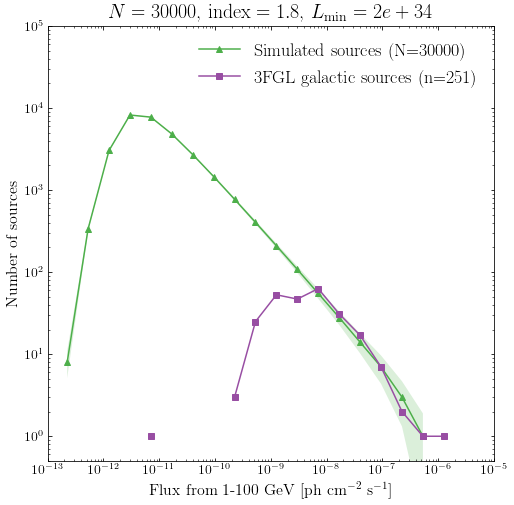

In [153]:
R_spec1,std_R1,lb_frac,std_lb_frac = ave_samples(500,Nsnr=30000,LF_i_snr=1.8,
                            Lmin_snr=2e34,Lmax_snr=2e39,
                            plothist=True,printstatements=False,
                           alpha=alp,beta=bet,H=H,
                           hist_3fgl=hist_3fgl_all,ft=5e-10,spectrum=intp_3fgl_all_normed)

In [156]:

def plot_spec(R_spec,std_R,plot=False):

    snr_spec_R = np.array(R_spec)
    std_snr_spec_R = np.array(std_R)
  
    if plot:
        fig = plt.figure(figsize=(10,14))
        gs = gridspec.GridSpec(4,2)
    
    iE100 = np.argmin(E<100)
    l_i_30 = []
    l_i_200 = []
    err_i_30 = []
    err_i_200 = []
    mask_E_2_30 = (E>=2)&(E<30)
    mask_E_30_200 = (E>=30)&(E<230)
    mask_E_2_200 = (E>=2)&(E<230)

    for ri in range(len(R_rings)):
        spec_sim_diff_unres = fit_rings_spec_27[ri]+snr_spec_R[ri]
        if plot:
            gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[ri])
            ax = plt.Subplot(fig,gs[ri]) 
            ax.loglog(E,E**2*fit_rings_spec_27[ri],label='Diffuse emission (index=2.7)',linestyle='--',color=c2)
            ax.loglog(E,E**2*(spec_sim_diff_unres),label='Diffuse (2.7) + Unresolved Sources',linestyle='-',color=c4)
            ax.fill_between(E,E**2*(spec_sim_diff_unres-std_snr_spec_R[ri]),
                            E**2*(spec_sim_diff_unres+std_snr_spec_R[ri]),alpha=0.2,facecolor=c4)

            ax.loglog(E,E**2*fit_rings_spec[ri],linestyle=':',label='Diffuse emission data (index varies)',color=c3)

            ax.loglog(E,E**2*snr_spec_R[ri],linestyle='-',label='Unresolved Sources',color=c6)

            ax.fill_between(E,E**2*(snr_spec_R[ri]-std_snr_spec_R[ri]),
                            E**2*(snr_spec_R[ri]+std_snr_spec_R[ri]),alpha=0.2,facecolor=c6)

            ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)

            ax.set_ylabel(r"$E^2 dN/dE$  $\rm [GeV\,cm^{-2} \, s^{-1}]$")
            ax.set_xlabel(r"$E$ [GeV]")
            ax.set_title('Full ROI')
            ax.set_ylim([0.1*min(1000**2*spec_sim_diff_unres), 10*max(spec_sim_diff_unres)])
            ax.set_xscale('log',nonposx='clip')
            ax.set_yscale('log',nonposy='clip')
            ax.set_title(r'R: %s - %s kpc'%R_rings[ri])

            fig.add_subplot(ax)
            plt.legend(loc=0,frameon=False)
        
        fit,cov = fit_index(E[mask_E_2_200],spec_sim_diff_unres[mask_E_2_200],std_snr_spec_R[ri][mask_E_2_200])

        l_i_200.append(fit[1])

        err_i_200.append(np.sqrt(cov[1][1]))
    
    if plot:
        fig.tight_layout(rect=[0, 0.03, 1, 0.95]);
    return l_i_200,err_i_200
    #plt.savefig('spec_diff+unres_29000_3FGL_hard.pdf',bbox_inches='tight')

def plot_trend(l_i,l_i_err,options):
    #Plot R trend
    f2,ax2 = plt.subplots(1,figsize=(9.5,5))
    ax2.errorbar(np.mean(R,axis=1),sf_2_200,xerr=(np.mean(R,axis=1)-R[:,0]),yerr=sf_2_200_err,
                marker='s',linestyle='',color='k',label='Diffuse data')
    colors =[c1,c2,c3,c4,c5,c6,c7,c8,c9]
    for ij, il in enumerate(l_i):
    
        ax2.errorbar(np.mean(R,axis=1),il,xerr=(np.mean(R,axis=1)-R[:,0]),yerr=l_i_err[ij],
                 color=colors[ij],marker='o',linestyle='',label=options[ij])
    #if l_i2 !=None:
    #    ax2.errorbar(np.mean(R,axis=1),l_i2,xerr=(np.mean(R,axis=1)-R[:,0]),yerr=l_i2_err,
    #             color=c3,marker='o',linestyle='',
    #                 label=r'Diffuse(2.7)+unresolved PS (threshold$=5 \times 10^{-9}$)')  
    
    ax2.set_xlim([0,35]);
    ax2.set_ylim([2.1,3.2]);
    plt.minorticks_on()
    ax2.set_xlabel(r'$R \ [\mathrm{kpc}]$',fontsize=16)
    ax2.set_ylabel(r'Spectral index',fontsize=16)
    ax2.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
    plt.legend(loc=4,frameon=False,fontsize=15,bbox_to_anchor=[1,0],ncol=2)
    plt.savefig('index_unresolved_options.pdf')

Doing 500 sample galaxys with 10000 sources,SNR_LF_i = 1.8, this might take some time...
17.0 19
...done
Doing 500 sample galaxys with 10000 sources,SNR_LF_i = 2.1, this might take some time...
17.0 19
...done
Doing 500 sample galaxys with 39000 sources,SNR_LF_i = 2, this might take some time...
20.0 19
...done
Doing 500 sample galaxys with 3000 sources,SNR_LF_i = 1.5, this might take some time...
22.0 19
...done
Doing 500 sample galaxys with 60000 sources,SNR_LF_i = 2.1, this might take some time...
20.0 19
...done
Doing 500 sample galaxys with 20000 sources,SNR_LF_i = 1.8, this might take some time...
21.0 19
...done


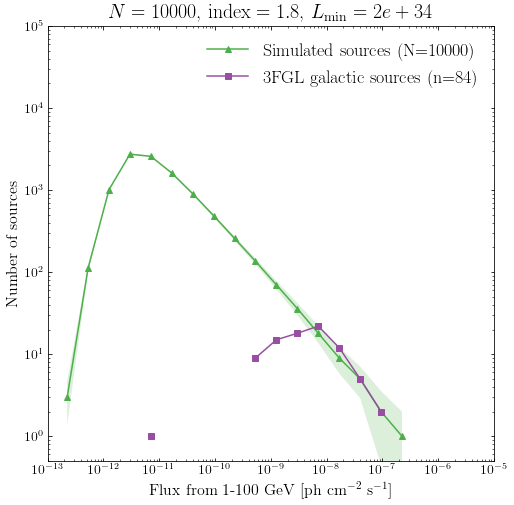

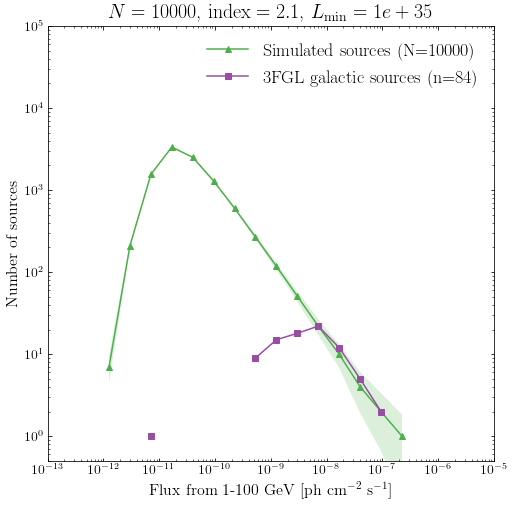

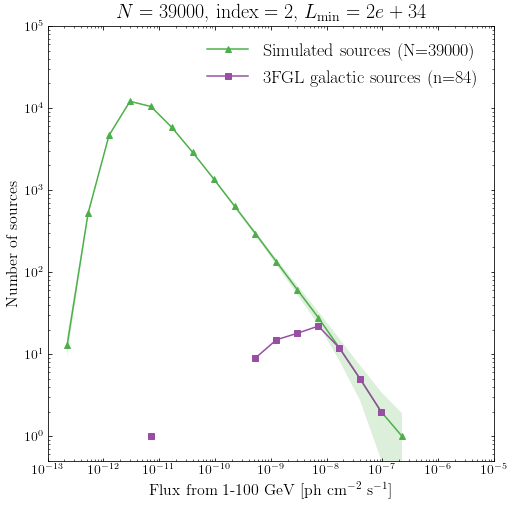

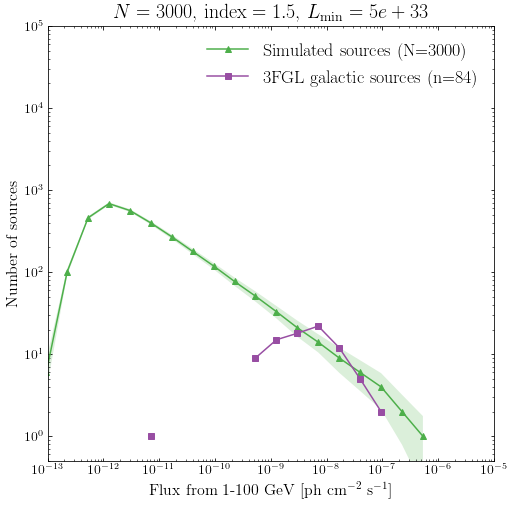

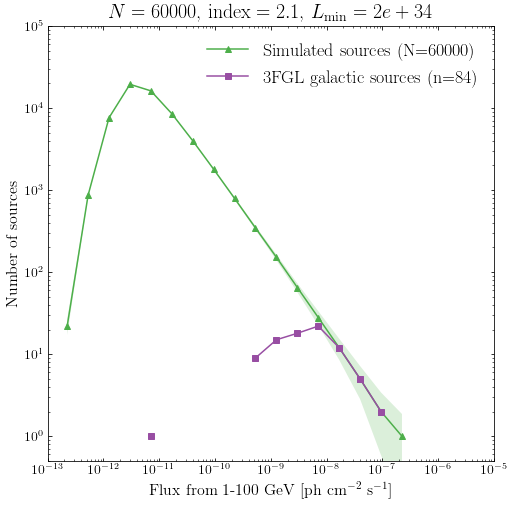

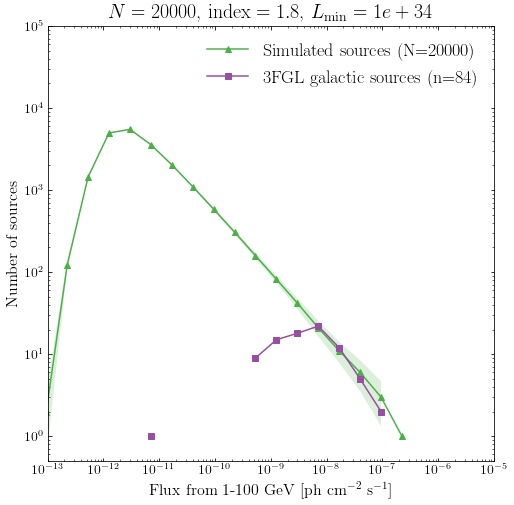

In [157]:
###Only SNR/spp/pwn population

options = [(10000,1.8,2e34),(10000,2.1,1e35),(39000,2,2e34),(3000,1.5,5e33),
           (60000,2.1,2e34),(20000,1.8,1e34)]

ind = []
ind_err = []
frac_op = []
std_frac_op = []
for op in options:
    R_spec1,std_R1,lb_frac,std_lb_frac = ave_samples(500,Nsnr=op[0],LF_i_snr=op[1],
                            Lmin_snr=op[2],Lmax_snr=2e39,
                            plothist=True,printstatements=False,
                           alpha=alp,beta=bet,H=H,
                           hist_3fgl=hist_3fgl_snr,ft=5e-10,spectrum=intp_3fgl_snr_normed)

    l1, l1_err = plot_spec(R_spec1,std_R1,plot=False)
    ind.append(l1)
    ind_err.append(l1_err)
    frac_op.append(lb_frac)
    std_frac_op.append(std_lb_frac)
frac_op = np.array(frac_op)
std_frac_op = np.array(std_frac_op)

#plot_trend(ind,ind_err,options)

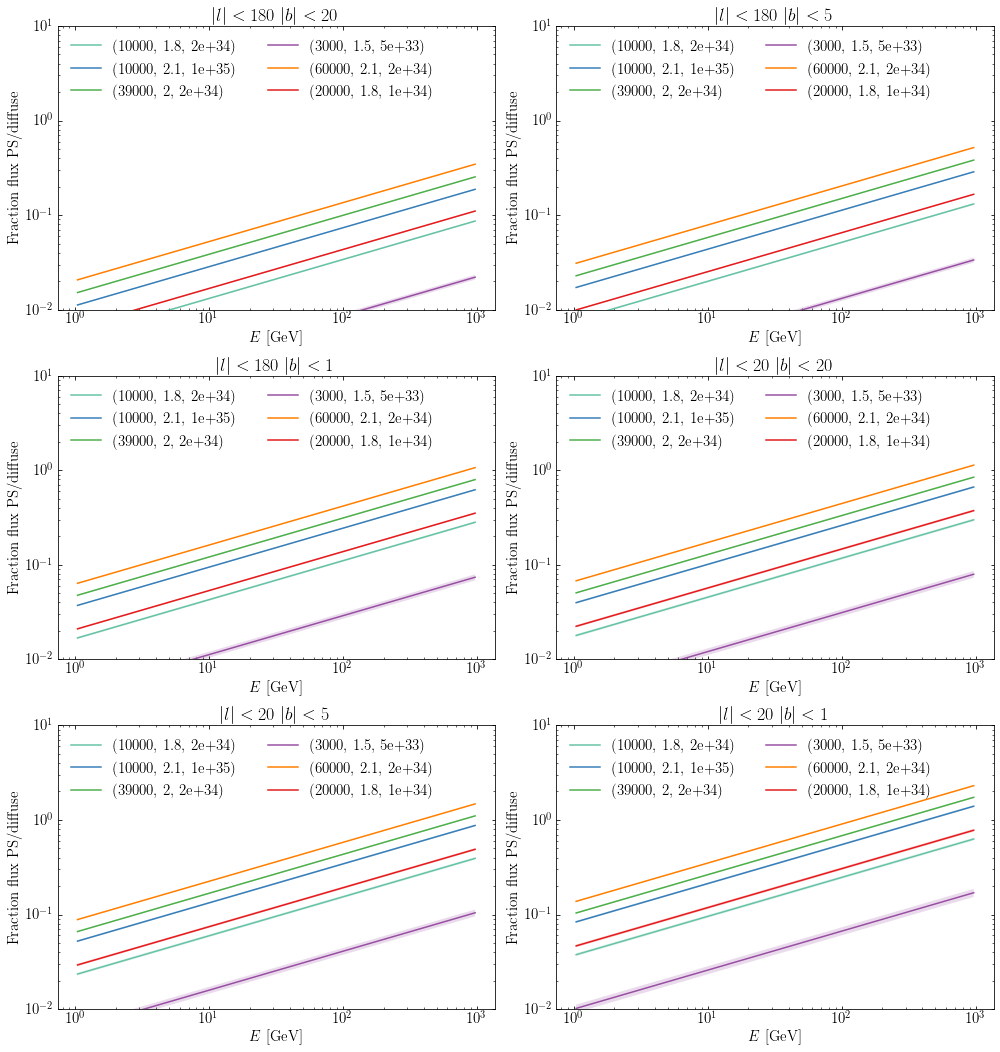

In [145]:
fig = plt.figure(figsize=(14,16))
gs = gridspec.GridSpec(3,2)

for di in range(len(lb)):
    #print "At abs(l,b):",lb[di]
    gsi = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=gs[di])
    ax = plt.Subplot(fig,gs[di]) 
    for i,sf in enumerate(frac_op[:,di]):
        #print options_print[i]
        div = frac_op[i,di]
        ax.loglog(E,div,color=colors[i],label=options[i])
        ax.fill_between(E,div-std_frac_op[i,di],div+std_frac_op[i,di],alpha=0.2,facecolor=colors[i])
        ax.set_xscale('log',nonposx='clip')
        ax.set_yscale('log',nonposy='clip')
        #print "At %.1f GeV the fraction is %.2f "%(E[iE100],div[iE100])
    ax.set_ylim([0.01,10])
    ax.set_title(r'$|l| < %s \ |b| < %s$'%lb[di],fontsize=18)
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=15)
    ax.set_xlabel(r"$E$ [GeV]",fontsize=15)
    ax.set_ylabel('Fraction flux PS/diffuse',fontsize=15)
    fig.add_subplot(ax)
    plt.legend(loc=2,frameon=False,fontsize=15,ncol=2)#, title=options_labels[0:4])
##Plot legend in seperate subplot
#fig2.suptitle(r'PS index = %s, diffuse index = 2.52-2.61'%(snr_index),fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('fraction_ps_diffuse.pdf')